# Probability and Applied Statistics Final Project
## Isaac Burmingham & Tyler LaLonde

For our final project, we chose to analyze the top 1000 times of all Olympic distances and the half-marathon. The data was taken from Kaggle (https://www.kaggle.com/jguerreiro/running). This Python code outlines the tests that were done on some of the data. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium
import datetime
import time
import statsmodels.api as sm
%matplotlib inline

df = pd.read_csv('/Users/Isaac/Probability & Applied Stats/data.csv') # read in data

df

,Rank,Time,Name,Country,Date of Birth,Place,City,Date,Gender,Event
0,1,00:01:40.910000,David Rudisha,KEN,1988-12-17,1.0,London,2012-09-08,Men,800 m
1,2,00:01:41.010000,David Rudisha,KEN,1988-12-17,1.0,Rieti,2010-08-29,Men,800 m
2,3,00:01:41.090000,David Rudisha,KEN,1988-12-17,1.0,Berlin,2010-08-22,Men,800 m
3,4,00:01:41.110000,Wilson Kipketer,DEN,1970-12-12,1.0,Köln,1997-08-24,Men,800 m
4,5,00:01:41.240000,Wilson Kipketer,DEN,1970-12-12,1.0,Zürich,1997-08-13,Men,800 m
...,...,...,...,...,...,...,...,...,...,...
18239,1000,00:03:33.250000,Noureddine Morceli,ALG,1970-02-28,1.0,Moskva,1995-06-05,Men,1500 m
18240,1000,00:03:33.250000,Paul Korir,KEN,1977-07-15,5.0,Zürich,2003-08-15,Men,1500 m
18241,1000,00:03:33.250000,Hudson Santos de Souza,BRA,1977-02-25,5.0,Rieti,2005-08-28,Men,1500 m
18242,1000,00:03:33.250000,Issac Songok,KEN,1984-04-25,2.0,Stockholm,2006-07-25,Men,1500 m


In [2]:
# calculate a new time as a float instead of a string.

df["newTime"] = df["Time"].apply(lambda x:int(x.split(":")[0]) + 
                                                              int(x.split(":")[1]) + float(((x.split(":")[2]))))

In [4]:
df["Year"] = pd.to_datetime(df["Date"]).apply(lambda x:x.year)

In [5]:
countries = df['Country'].unique().tolist()
len(countries)

106

Calculate the age of each athlete,

In [7]:
df['yearbirth'] = pd.to_datetime(df["Date of Birth"]).apply(lambda x:x.year)
df['Age'] = df['Year'] - df['yearbirth']

# Test of Independence: Age and Place

A Chi-Squared test of independence was performed on the age and place of each athlete, to determine whether the variables were independent.

Null Hypothesis: Age and Place are independent. 
Alternative Hypothesis: Age and Place are dependent.

In order to clean things up, the ages were binned into a range. This was so that we did not have a large number of columns. We also restricted the place to only the top 3, which would be considered podium places. In order to calculate Chi-Squared, we need a table of observed values. This is done with the pd.crosstab method. 

In [9]:
def bin_age(df):
    cut_points = [15,19,24,29,34,39,49]
    label_names = ["15-19","20-24","25-29","30-34","35-39","40-49"]
    df["binned_age"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

grouped_age = bin_age(df)

medalsdf2 = grouped_age[grouped_age['Place'] <= 3.0]

ageplacef = pd.crosstab(medalsdf2['Place'],grouped_age['binned_age'],margins=True)
ageplacef

binned_age,15-19,20-24,25-29,30-34,35-39,40-49,All
Place,,,,,,,
1.0,210,3013,3261,1278,197,8,7967
2.0,104,1398,1630,669,96,5,3902
3.0,72,767,945,426,58,4,2272
All,386,5178,5836,2373,351,17,14141


Let's visualize the data. This heatmap easily shows us which age is optimal for achieving a 1st place finish and so on where the "hotter" regions are the regions with the most counts in our data. So it seems that the range between 21-29 is the best range for a first place finish.

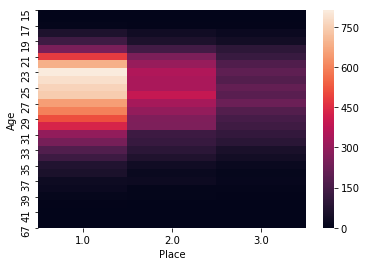

In [10]:
sns.heatmap(pd.crosstab(medalsdf2['Age'],medalsdf2['Place']))

Next, we need to move our frequency table into a numpy array so that our chi2 function will work.

In [13]:
f_obs = np.array([ageplacef.iloc[0][:].values, ageplacef.iloc[1][:].values,ageplacef.iloc[2][:].values])

Using a package called scipy, calculating the chi-squared is easily done. We do not need to calculate the expected values table since it is scipy computes it for us. The output is (Chi-Squared Value, p-value, df)

In [14]:
from scipy import stats
stats.chi2_contingency(f_obs)[0:3]

(20.396264899749262, 0.025719785249870338, 10)

In [15]:
d = {'Chi Squared': ['20.3963'],'Alpha Level':['0.05'],'p-value': ['0.02572'],'Degrees of Freedom':['10'],'Accept/Reject':['Reject the Null'],'Error Type':['Type I']}
results = pd.DataFrame(data=d)
results.rename(index = {0:'Age and Top 3 Place'},inplace = True)
results

,Chi Squared,Alpha Level,p-value,Degrees of Freedom,Accept/Reject,Error Type
Age and Top 3 Place,20.3963,0.05,0.02572,10,Reject the Null,Type I


As a result, reject the null in favor of the alternative hypothesis and conclude that Age and a Top 3 finish are dependent.

# Test of Independence: Country and Place

We can do the same as above.

In [18]:
cplace = pd.crosstab(medalsdf2['Place'],medalsdf2['Country'])
f_obs2 = np.array([cplace.iloc[0][:].values, cplace.iloc[1][:].values,cplace.iloc[2][:].values])
cplace

Country,AHO,AIA,ALG,ANT,ARG,AUS,AUT,AZE,BAH,BAR,...,TTO,TUR,UAE,UGA,UKR,USA,UZB,VEN,ZAM,ZIM
Place,,,,,,,,,,,,,,,,,,,,,
1.0,5,0,67,9,0,75,6,1,83,6,...,90,30,0,7,99,1793,4,0,2,5
2.0,1,1,19,2,1,17,6,0,35,7,...,37,4,1,11,57,681,9,2,0,3
3.0,1,0,11,3,0,22,3,0,26,3,...,22,5,0,10,40,318,2,1,0,0


In [19]:
stats.chi2_contingency(f_obs2)[0:3]

(658.7397769190708, 8.150672238774324e-50, 202)

In [20]:
d = {'Chi Squared': ['658.7398'],'Alpha Level':['0.05'],'p-value': ['0'],'Degrees of Freedom':['202'],'Accept/Reject':['Reject the Null'],'Error Type':['Type I']}
results = pd.DataFrame(data=d)
results.rename(index = {0:'Country and Top 3 Place'},inplace = True)
results

,Chi Squared,Alpha Level,p-value,Degrees of Freedom,Accept/Reject,Error Type
Country and Top 3 Place,658.7398,0.05,0,202,Reject the Null,Type I


So when testing between country and a top 3 finish, we find that these are associated as well.

# ANOVA Test: Age and Event

Next we wanted to do an ANOVA Test to see if the average age among all 9 events were equal or at least one was significantly different.

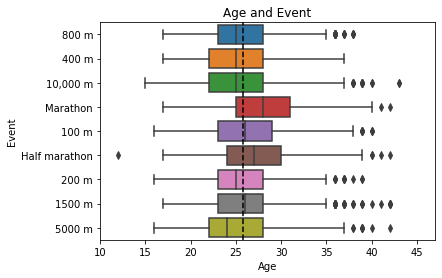

In [24]:
sns.boxplot(x='Age',y='Event',data=df)
plt.xlim(10,47)
plt.title('Age and Event')
plt.xlabel('Age')
plt.ylabel('Event')
plt.axvline(25.8,0,1,c='black',linestyle='--')
plt.show()

This box plot shows the average age among each event and their standard deviations. The black dashed line is the average age of all nine events which is 25.8. To perform the ANOVA test, an ANOVA table was calculated using the statsmodel package.

In [25]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
mod = ols('Age ~ Event',data=df).fit()
anov_tab = sm.stats.anova_lm(mod,typ=2)
anov_tab.rename(columns={'PR(>F)':'p-value (>F)'})

,sum_sq,df,F,p-value (>F)
Event,17820.175970,8.0,137.498844,2.731934e-225
Residual,295412.401096,18235.0,NaN,NaN


Since the p-value is about equal to 0, this tells us that at least one comparison is significantly different. So, we want to figure out which comparisons are and aren't. To do this, we must run a post-hoc analysis.

## Post-hoc Analysis

In [28]:
pair_t = mod.t_test_pairwise('Event',method = 'bonferroni')
pairtdf = pair_t.result_frame
pairtdf
reject = pairtdf[pairtdf['reject-bonferroni'] == True]
pairtdf.head()

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-bonferroni,reject-bonferroni
"100 m-10,000 m",0.824553,0.124902,6.601613,4.179147e-11,0.579734,1.069372,1.504493e-09,True
"1500 m-10,000 m",0.298920,0.127281,2.348507,1.885947e-02,0.049438,0.548403,6.789411e-01,False
"200 m-10,000 m",-0.276421,0.126766,-2.180555,2.922911e-02,-0.524895,-0.027947,1.000000e+00,False
"400 m-10,000 m",-0.518250,0.127077,-4.078249,4.556890e-05,-0.767332,-0.269168,1.640480e-03,True
"5000 m-10,000 m",-0.715740,0.127344,-5.620507,1.931832e-08,-0.965346,-0.466133,6.954595e-07,True


In [32]:
len(pairtdf)

36

For the sake of space I only printed out the first 5 comparisons. There are 36 in total (9 choose 2). The Bonferroni method was chosen in order to reduce our Type I Error inflation. Since we have so many comparisons, the error rate at our original significance level of 0.05 was,

In [29]:
1-(1-0.05)**36

0.8422207852117732

So using the Bonferroni method, we can calculate a new alpha level by dividing 0.05 by the number of comparisons.

In [30]:
0.05/36

0.001388888888888889

In [31]:
1-(1-0.001389)**36

0.048807444408204836

This gives us a much better error rate of 0.0488. So, based on the reject-bonferroni column, we can determine which are significantly different. If it is True, then they are the comparisions that are significantly different at our new alpha level.

In [33]:
pairtdf['reject-bonferroni'].value_counts()

True     29
False     7
Name: reject-bonferroni, dtype: int64

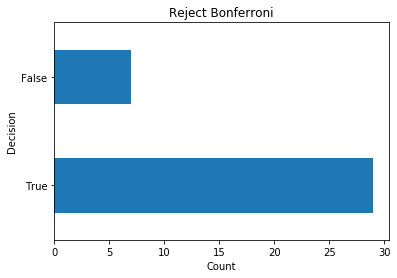

In [35]:
pairtdf['reject-bonferroni'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Decision')
plt.title('Reject Bonferroni')
plt.show()

So you can see, the majority of the comparisons were significantly different. 

# Hypothesis Test of Age and Event
This was performed in Excel. An estimate of the total age for all events was determined to be 20 and used as our null hypothesis. Our alternative hypothesis was that the average age was not 20. Then, the p-value for each was calculated. Using an alpha level of 0.05, we determined whether to reject or fail to reject the null. The graphs outline the age per event, as well a line plot of the p-values as a function of event, indicating which were rejected if they fell below the line of 0.05, and which were accepted.  